# Data:
Monthly retail sales data in millions of dollars

Taken from: https://fred.stlouisfed.org/series/RSCCASN 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/julesbellosguardo/Downloads/RSCCASN_.csv', index_col='DATE', parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
len(df)

334

<Axes: xlabel='DATE'>

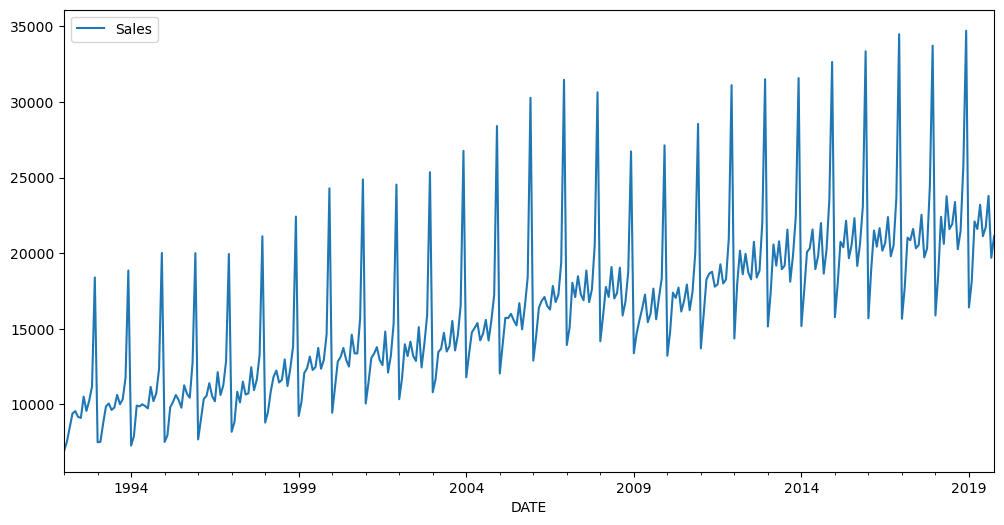

In [7]:
df.plot(figsize = (12,6))

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

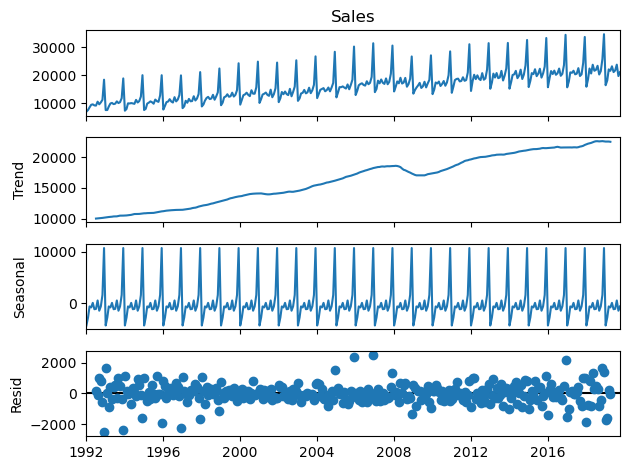

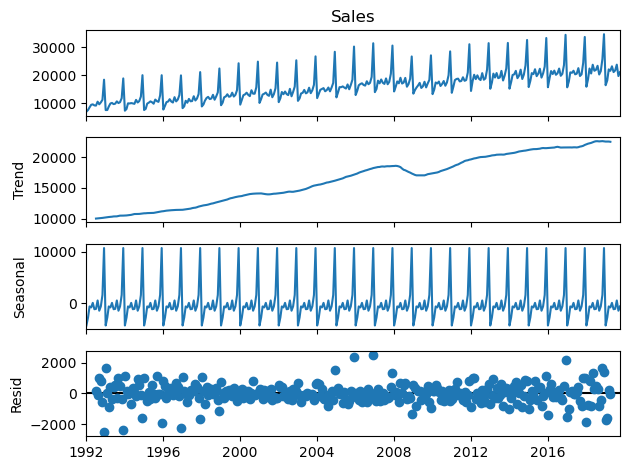

In [17]:
seasonal_decompose(df['Sales'], period=12).plot()

### Splitting into Train and Test Set + Scaling:

In [27]:
test_length = 18
train = df.iloc[:-test_length]
test = df.iloc[-test_length:]

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [29]:
scaler.fit(train)

MinMaxScaler()

In [30]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### Producing batches for training and model validation:

In [26]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [31]:
length = 12

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [39]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [44]:
#Visualizing how generator operates:

X, y = generator[0]
print(f'Given these 12 points: {X.flatten()},')
print('\n')
print(f'Predict this next point: {y}')

Given these 12 points: [0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266],


Predict this next point: [[0.02047633]]


### Building the Model:

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
num_features = 1 #Univariate data

In [46]:
model = Sequential()
#LSTM Layer:
model.add(LSTM(units=100, activation='relu', input_shape = (length, num_features)))
#Output Layer:
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [48]:
#Incorporating Early Stopping:
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [50]:
#Creating a generator for validation data:

val_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)

In [51]:
#Fitting Model:

model.fit_generator(generator = generator, epochs = 25, callbacks=[early_stop], validation_data= val_generator)

/var/folders/18/_q0z_1k55hb814fgjk4yb8pc0000gn/T/ipykernel_34903/1375856527.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generator, epochs = 25, callbacks=[early_stop], validation_data= val_generator)
2024-07-13 11:02:51.173638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/25
302/304 [============================>.] - ETA: 0s - loss: 0.0238

2024-07-13 11:02:54.684464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


304/304 [==============================] - 4s 6ms/step - loss: 0.0237 - val_loss: 0.0042
Epoch 2/25
304/304 [==============================] - 2s 6ms/step - loss: 0.0174 - val_loss: 0.0045
Epoch 3/25
304/304 [==============================] - 2s 6ms/step - loss: 0.0087 - val_loss: 0.0067


In [52]:
losses = pd.DataFrame(model.history.history)
losses.head()

,loss,val_loss
0,0.023660,0.004193
1,0.017401,0.004458
2,0.008725,0.006669


<Axes: >

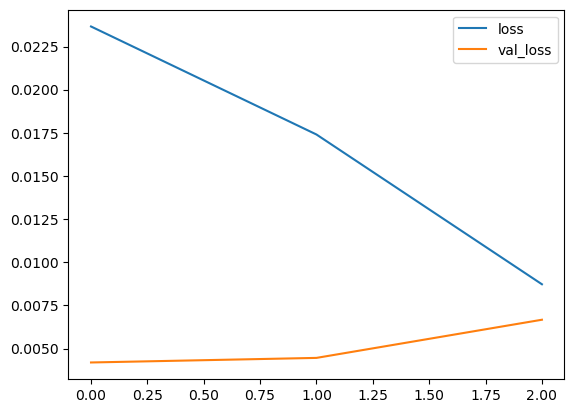

In [54]:
losses.plot()

#### Evaluating on Test Data:

In [67]:
len(test)

18

In [83]:
test_predictions = []

first_eval_batch = scaled_train[-length:] #Last 12 values of test data, enough to capture seasonality
current_batch = first_eval_batch.reshape((1, length, num_features))

for i in range(len(test)):
    
    current_prediction = model.predict(current_batch)[0]
    #Append prediction to list of predictions:

    test_predictions.append(current_prediction)

    #Update batch, drop first value and include prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis= 1) #Current_prediction in appropriate dimension to be appended
    

1/1 [==============================] - 0s 35ms/step


In [84]:
test_predictions

[array([0.5808091], dtype=float32),
 array([0.5504606], dtype=float32),
 array([0.5601711], dtype=float32),
 array([0.6163203], dtype=float32),
 array([0.5472816], dtype=float32),
 array([0.57036453], dtype=float32),
 array([0.77331865], dtype=float32),
 array([1.0285282], dtype=float32),
 array([0.46790063], dtype=float32),
 array([0.53942746], dtype=float32),
 array([0.6453167], dtype=float32),
 array([0.6035031], dtype=float32),
 array([0.6743407], dtype=float32),
 array([0.65627044], dtype=float32),
 array([0.6712938], dtype=float32),
 array([0.7241882], dtype=float32),
 array([0.6752717], dtype=float32),
 array([0.71723837], dtype=float32)]

In [85]:
#Reverse original transformation on data to get true predictions:

true_predictions = scaler.inverse_transform(test_predictions)

In [86]:
true_predictions

array([[22935.80630112],
       [22099.88613319],
       [22367.35353088],
       [23913.92667437],
       [22012.32502079],
       [22648.12074804],
       [28238.28884983],
       [35267.78111267],
       [19825.85505772],
       [21795.98993731],
       [24712.60373592],
       [23560.88960743],
       [25512.04092789],
       [25014.31312037],
       [25428.11629248],
       [26885.04001713],
       [25537.68342638],
       [26693.61356974]])

In [88]:
test.head()

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


In [89]:
test['Predictions'] = true_predictions
test.head()

/var/folders/18/_q0z_1k55hb814fgjk4yb8pc0000gn/T/ipykernel_34903/94108889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


,Sales,Predictions
DATE,,
2018-05-01,23764,22935.806301
2018-06-01,21589,22099.886133
2018-07-01,21919,22367.353531
2018-08-01,23381,23913.926674
2018-09-01,20260,22012.325021


<Axes: xlabel='DATE'>

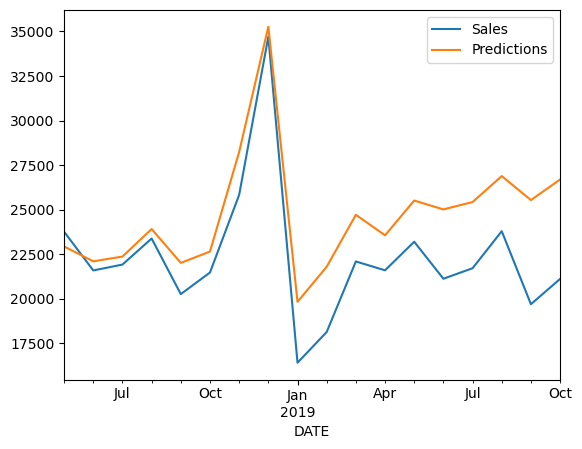

In [91]:
test[['Sales', 'Predictions']].plot()

## Forecasting:

In [93]:
new_scaler = MinMaxScaler()
full_scaled_data = new_scaler.fit_transform(df)

In [94]:
length = 12
new_generator = TimeseriesGenerator(full_scaled_data, full_scaled_data, length = length, batch_size=1)

In [95]:
#New Model:

new_model = Sequential()

new_model.add(LSTM(100, activation='relu', input_shape = (length, num_features)))

new_model.add(Dense(1))

new_model.compile(optimizer='adam', loss='mse')

In [96]:
new_model.fit_generator(generator= new_generator, epochs = 3)

Epoch 1/3


/var/folders/18/_q0z_1k55hb814fgjk4yb8pc0000gn/T/ipykernel_34903/1185453826.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  new_model.fit_generator(generator= new_generator, epochs = 3)
2024-07-13 11:26:30.811605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


322/322 [==============================] - 4s 5ms/step - loss: 0.0259
Epoch 2/3
322/322 [==============================] - 2s 6ms/step - loss: 0.0186
Epoch 3/3
322/322 [==============================] - 2s 6ms/step - loss: 0.0121


In [98]:
#Forecasting:

forecasts = []

forecasting_periods = 12

first_batch = full_scaled_data[-length:]
current_batch = first_batch.reshape((1, length, num_features))

for i in range(forecasting_periods):
    current_pred = model.predict(current_batch)[0]

    forecasts.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 34ms/step


In [99]:
#True forecasts:

true_forecasts = new_scaler.inverse_transform(forecasts)

In [100]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [101]:
forecast_index = pd.date_range(start='2019-11-01', periods= forecasting_periods, freq='MS')

In [103]:
df_with_forecasts = pd.DataFrame(data = true_forecasts, columns=['Forecasts'], index = forecast_index)

In [104]:
df_with_forecasts.head()

,Forecasts
2019-11-01,28807.544980
2019-12-01,36292.070791
2020-01-01,19931.689308
2020-02-01,21310.301367
2020-03-01,24249.944182


<Axes: >

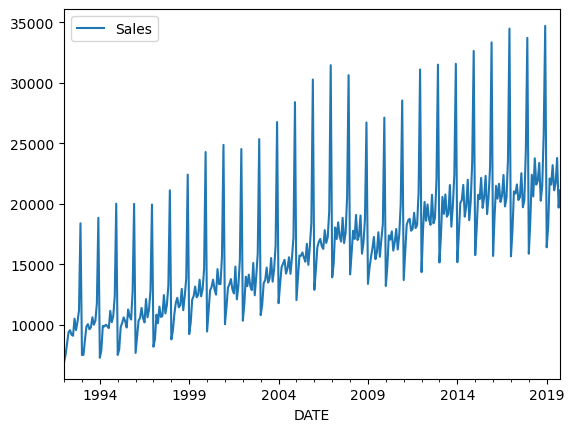

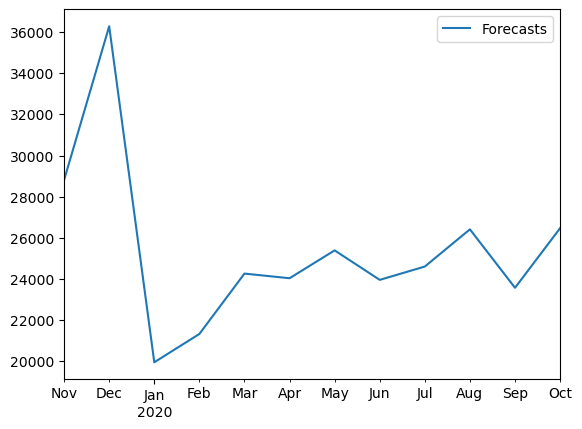

In [105]:
df.plot()
df_with_forecasts.plot()

<Axes: xlabel='DATE'>

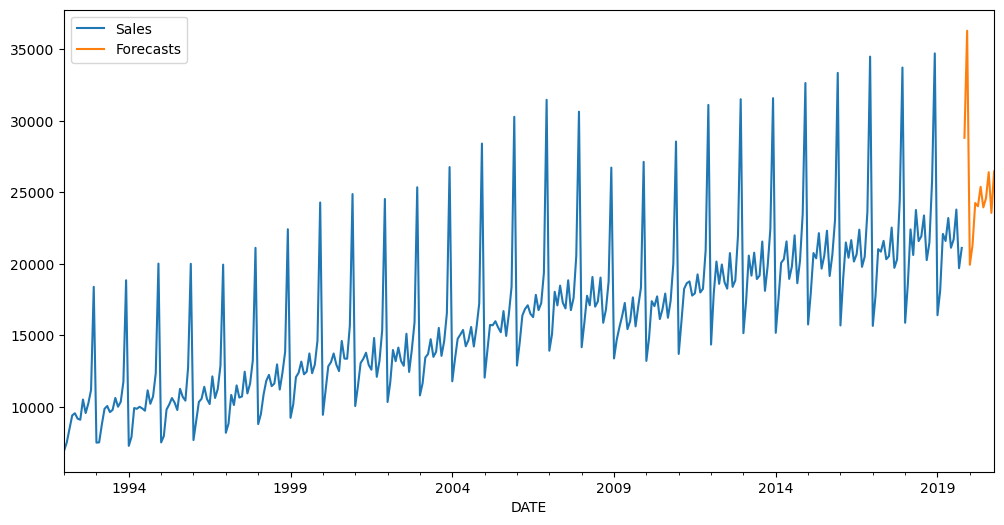

In [107]:
#Plots of original data plus forecasts:
ax = df.plot()
df_with_forecasts.plot(ax=ax, figsize = (12,6))

(574.0, 609.0)

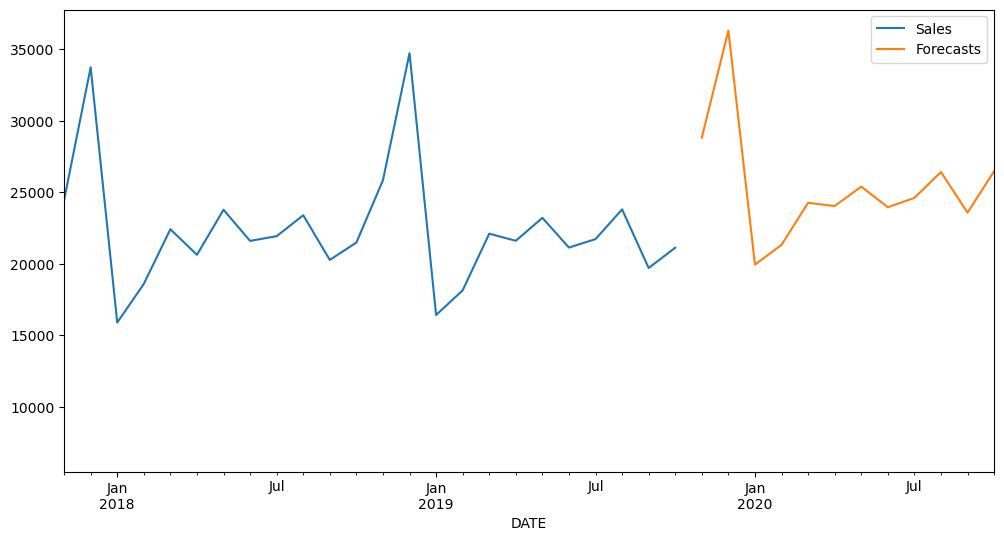

In [109]:
#Zooming in on forecasts:
ax = df.plot()
df_with_forecasts.plot(ax=ax, figsize = (12,6))
plt.xlim(('2017-11-01', '2020-10-01'))